# Astropy Quantities

In astronomy (and most sciences) we typically have to deal with quantities which have some dimension (i.e. unit). The quantity is completely represented by not only a number but also a unit to go alongwith it. When we consider the same quantity in a different unit system, the quantity itself will not change, although the number used to represent it does change. While solving involved problems with several dimensional quantities, it may become cumbersome to keep track of the quantity if our program stores it as a single number with implied unit. Astropy units library is a useful way to keep track of a dimensional quantity 

In [2]:
import numpy as np
from astropy import units as u 
#The first step as usual is to import the required packages

We can initialise a dimensional quantity as follows

In [3]:
q = 42.0 * u.m 
lengths = [1,2,3]*u.m

We can access the numerical and unit part of q as follows

In [4]:
print(q.value,q.unit) #Ofcourse, we can use q.value with any other command also

print(lengths.value,q.unit)
print(lengths[0].value , lengths[0].unit)


42.0 m
[1. 2. 3.] m
1.0 m


We can multiply or divide quantities having different units but not add/subtract. Ofcourse, quantities with same unit can be added as usual. Trying to add incompatible quantities will give unit conversion error

In [5]:
distance2 =45 * u.m
distance1 =5*u.m
time = 2 * u.s

In [6]:
speed = (distance2 - distance1)/time
print(speed)

20.0 m / s


We can also use units library to interconvert between different unit systems using the to() method. Note that after calling this method, the value stored in quantity.value and quantity.unit don't change. Another method for converting to cgs/SI is also shown below.

In [7]:
print(speed.to(u.km/u.hour))
print(speed.value)
print(speed.unit)
print((1*u.Joule).cgs)
print((10*u.cm).si)

72.0 km / h
20.0
m / s
10000000.0 erg
0.1 m


We can also define new suitable units as required.

In [8]:
mph = u.imperial.mile/u.hour #astropy.units.imperial is the module for fps units
print(speed.to(mph))

44.73872584108805 mi / h


A special type of unit in the astropy.units package is the dimensionless quantity. This can either be initialised directly or come out from units cancelling out.

In [9]:
refractive_index = 1.5 *u.dimensionless_unscaled
print(refractive_index.value,refractive_index.unit) #No unit is printed, as the quantity is dimensionless

distance_ratio1 = (1*u.m)/(2*u.m)
print(distance_ratio1.value,distance_ratio1.unit)#This is a true unscaled dimensionless quantity

distance_ratio2 = (1*u.km)/(2*u.m)
print(distance_ratio2.value,distance_ratio2.unit)#This is also dimensionless, but value is scaled

print(distance_ratio1.unit == refractive_index.unit)#both are dimensionless unscaled
print(distance_ratio1.unit == distance_ratio2.unit)#both are dimensionless, but one is scaled, the other is not

1.5 
0.5 
0.5 km / m
True
False


Ofcourse, astropy being 'astro'py, does support usual astronomical units like parsecs, solar masses, AU etc

In [10]:
r = 1*u.AU
d = 1*u.parsec
print(d/r)
print(float(d/r)) #Notice how the float method is used to convert dimensionless scaled quatities to numbers
                  #The float method will not work with quantities having some dimension

AvgDensity_of_sun = 1*u.Msun/(4*np.pi/3*(1*u.Rsun)**3)
print(AvgDensity_of_sun.to(u.kg/u.m**3)) #Side note: note how this quite close to density of water

1.0 pc / AU
206264.8062454803
1409.8262953659105 kg / m3


The last remark to make about astropy is that it can also do 'implicit' conversions, like converting wavelength of light to frequency (in vacuum), by specifying the equivalencies parameter

In [11]:
print((1000 * u.nm).to(u.Hz, equivalencies=u.spectral()))  

299792457999999.94 Hz


# Filters in Astronomy
Astronomers often use various filters for taking images. These filters selectively allow light of certain wavelengths to pass through them while rejecting others. Several filter systems are in use, and the filters used for a certain observation are usually specifiedd along with the observation data. Here, we will take up a specific filter system, SDSS (Sloan Digital Sky Survey). In general the analysis of any other filter system will also be similar. In this excersise, we will model a star as a perfect blackbody and try to find the intensity detected in each filter.

Recall that Planck's formula for the black body spectrum is given by:
$$B(\lambda,T) = \frac{2\pi hc^2}{\lambda^5}\left(\frac{1}{exp\left(\frac{hc}{\lambda k_BT}\right)-1}\right)$$
$h$ is the planck's constant, $c$ is the speed of light and $k_B$ is Boltzman constant. $\lambda$ and $T$ represent the wavelength at which $B$ is measured and temperature of blackbody, respectivley. 

$B(\lambda,T)d\lambda$ gives the  energy emitted per unit time per unit area of blackbody in the form of light having wavelengths within a wavelength interval of (small) width $d\lambda$ centred at said $\lambda$. We will first write a function that returns B with its proper unit (which is $Wm^{-3}$)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const #The constants package is a prebuilt package from astropy containing
                                       #all usual physical constants. They are prebuilt with their units

In [13]:
h = const.h
print(h)

  Name   = Planck constant
  Value  = 6.62607004e-34
  Uncertainty  = 8.1e-42
  Unit  = J s
  Reference = CODATA 2014


The complete list of constants available in astropy is available at https://docs.astropy.org/en/stable/constants/

In [14]:
c = const.c
kB = const.k_B

In [15]:
def B(wl,T): #lambda is a reserved keyword in python, so wavelength is assigned variable wl
    exponential = 1/(np.exp(h*c/(wl*kB*T))-1)
    prefactor = 2*np.pi*h*c*c/wl**5
    return prefactor*exponential

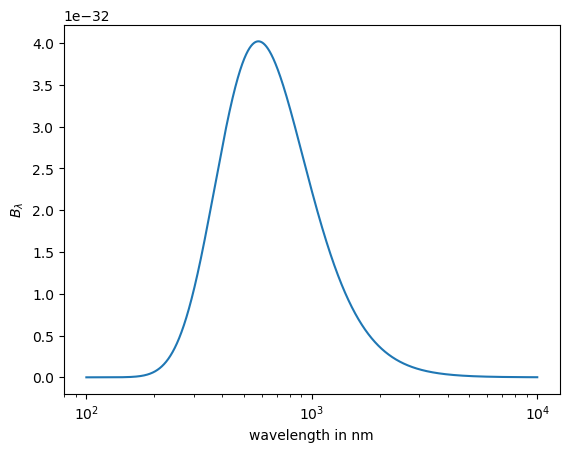

In [16]:
plt.style.use('default')
wl0 = np.linspace(100,10000,1000000)*u.nm
T0 = 5000 *u.K
plt.xscale('log')
plt.xlabel('wavelength in nm')
plt.ylabel('$B_\lambda$')
plt.plot(wl0.value,B(wl0,T0).value)
plt.show()

The next step is find out the filter response as a function of wavelength. For most standard filters, these are readily available from appropriate sources, as measured experimentally by some astronomer. For our purpose, we will be using the SDSS filters, and in particular ,the data from Jim Gunn,2001 (available from the SDSS website as a fits file, has been already included in the folder with this notebook)

In [17]:
from astropy.io import fits

In [18]:
SDSS_filter = fits.open('filter_curves.fits')
SDSS_filter.info()

Filename: filter_curves.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  U             1 BinTableHDU     20   47R x 5C   [E, E, E, E, E]   
  2  G             1 BinTableHDU     20   89R x 5C   [E, E, E, E, E]   
  3  R             1 BinTableHDU     20   75R x 5C   [E, E, E, E, E]   
  4  I             1 BinTableHDU     20   89R x 5C   [E, E, E, E, E]   
  5  Z             1 BinTableHDU     20   141R x 5C   [E, E, E, E, E]   


As you can see, the primary HDU is empty, since there is no image and only filled HDUs are the binary table HDUs corresponding to the five filters U/G/R/I/Z(ultraviolet/green/red/infrared/longer than infrared). We can see that each HDU contains 5 columns, and we can find out what they represent by looking at the headers

In [19]:
SDSS_filter[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20 / length of dimension 1                          
NAXIS2  =                   47 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = 'E       '                                                            
TUNIT1  = 'angstrom'                                                            
TTYPE2  = 'respt   '                                                            
TFORM2  = 'E       '        

As we can see, the first column is the wavelength in Angstroms and the further columns give the transparency of the filter at said wavelength, under various conditions. 'respt' is the quantum efficiency after going through 1.3 airmasses (i.e atmospheric scattering) while 'resbig' is the quantum efficiency including some infrared scattering effects, mainly applicable for extended objects (>80 pixels).'resnoa' is quantum efficiency with no atmosphere and last column represents assumed atmospheric transparency as a function of atmosphere. For our purposes, we will be using mainly the 'respt' column. 

In [20]:
U = SDSS_filter[1].data
G = SDSS_filter[2].data
R = SDSS_filter[3].data
I = SDSS_filter[4].data
Z = SDSS_filter[5].data

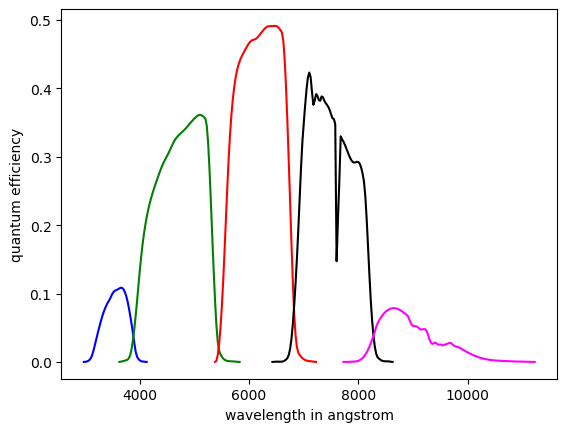

In [21]:
plt.plot(U.field(0),U.field(1),color='blue') #the 'field' attribute of binary data HDU is used to access it by column
plt.plot(G.field(0),G.field(1),color='green')
plt.plot(R.field(0),R.field(1),color='r')
plt.plot(I.field(0),I.field(1),color='black')
plt.plot(Z.field(0),Z.field(1),color='magenta')
plt.ylabel('quantum efficiency')
plt.xlabel('wavelength in angstrom')
plt.show()

The intensity of light observed in a certain filter is simply the integral of the product of $B(\lambda,T)$ and quantum efficiency profile of said filter, corrected for distance, integrated over all wavelengths. 
$$I_{net} = \frac{r^2}{d^2}\int_0^\infty B(\lambda,T) q(\lambda) d\lambda$$
where $q(\lambda)$ is the quantum efficiency, i.e fraction of photons that are let through where r is radius of the star, d is our distance from it and T is its temperature.

We will now try to calculate the intensity of the sun, as calculated in G filter, as an example

In [22]:
wavelengths = G.field(0)*u.AA
qG = G.field(1)
Tsirius = 9940 * u.K
r_sirius = 1.711*u.Rsun
d_sirius = 2.64 * u.pc 

In [23]:
#We will estimate the integral by trapezoidal rule
integral = 0*u.W/u.m**2
i = 1
while i < len(wavelengths):
    integral += B((wavelengths[i-1]+wavelengths[i])/2 , Tsirius)*(qG[i-1]+qG[i])/2*(wavelengths[i]-wavelengths[i-1])
    i = i + 1
intensity = integral*(r_sirius/d_sirius)**2
print(intensity.to(u.W/u.m**2))

7.0242139691731335e-09 W / m2


## Your task...
...should you accept it, is as follows:

Arcturus is one of the prominent stars from the Bootes constellation. An astronomer measures the intensity of Arcturus in the G and R filters of SDSS system and obtains the values of intensity as in the below cell. Estimate the temperature of Arcturus to within $\pm 50K$. You may assume that Arcturus behaves like a perfect blackbody (deviations from this assumption will be discussed in the next tutorial). The information provided below is sufficient for solving this question and no additional information (such as radius of Arcturus) is required.

In [24]:
intensity_G = 1.3887e-09 * (u.W / u.m**2)
intensity_R = 2.5553e-09 * (u.W / u.m**2)